In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import NNConv, BatchNorm, global_mean_pool, MessagePassing
from torch.nn import Sequential as Seq, Linear, ReLU, BatchNorm1d, Dropout

In [4]:
import numpy as np
import networkx as nx
import re
import os
import random
from torch_geometric.data import DataLoader

In [25]:
class CustomEdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='mean')  # "Max" aggregation.
        self.mlp = Seq(Linear(2 * in_channels + 3, out_channels), ReLU(), Linear(out_channels, out_channels))
    def forward(self, x, edge_index, edge_weight):
        return self.propagate(edge_index, x=x, edge_weight=edge_weight)
    def message(self, x_i, x_j, edge_weight):
        tmp = torch.cat([x_i, x_j - x_i, edge_weight.view(-1, 3)], dim=1)
        return self.mlp(tmp)

class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = CustomEdgeConv(in_channels, hidden_channels)
        self.out = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = F.sigmoid(self.out(x))
        return x

In [35]:
class CustomEdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mlp = Seq(Linear(2 * in_channels + 3, out_channels), ReLU(), Linear(out_channels, out_channels))
        self.lstm = torch.nn.LSTM(input_size=2 * in_channels + 3, hidden_size=out_channels, batch_first=True)

    def forward(self, x, edge_index, edge_weight):
        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, x_i, x_j, edge_weight):
        tmp = torch.cat([x_i, x_j - x_i, edge_weight.view(-1, 3)], dim=1)
        lstm_out, _ = self.lstm(tmp.unsqueeze(0))
        return self.mlp(lstm_out.squeeze(0))


In [26]:
def read_g_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return content

def get_relative_position(G, start_node, end_node):
    try:
        edge_data = G.get_edge_data(start_node, end_node)
        if edge_data is not None:
            relative_pos = edge_data['weight']
            return relative_pos
        else:
            print("No direct edge between these nodes.")
            return None
    except KeyError:
        print("One or both of the nodes do not exist in the graph.")
        return None

def parse_transform(transform_string):
    translation_match = re.search(r't\((.*?)\)', transform_string)
    if translation_match:
        translation_values = translation_match.group(1)
        return np.array([float(val) for val in translation_values.split()])
    return np.zeros(3)

def process_g_file(filepath):
    g_content = read_g_file(filepath)

    object_positions = {}
    object_transformations = {}

    for line in g_content.split('\n'):
        if line.strip() == "":
            continue
        position_match = re.match(r'object(\d+).*?X:\s*\[([^\]]+)\]', line)
        if position_match:
            obj_id = int(position_match.group(1)) - 1  # Subtract 1 to start from 0
            position = np.array([float(n) for n in position_match.group(2).split(', ')[:3]])  # Only take the first three values
            object_positions[obj_id] = position

        transform_match = re.match(r'object(\d+)\(object(\d+)\).*?Q:\s*"([^"]+)"', line)
        if transform_match:
            obj_id = int(transform_match.group(1)) - 1  # Subtract 1 to start from 0
            base_obj_id = int(transform_match.group(2)) - 1  # Subtract 1 to start from 0
            transform_string = transform_match.group(3)
            transformation = parse_transform(transform_string)
            object_transformations[obj_id] = (base_obj_id, transformation)

    G = nx.DiGraph()

    for obj_id in object_positions.keys():
        G.add_node(obj_id)

    for start_id, start_pos in object_positions.items():
        for end_id, end_pos in object_positions.items():
            if start_id != end_id:
                relative_pos = end_pos - start_pos
                G.add_edge(start_id, end_id, weight=relative_pos)

    for obj_id, (base_obj_id, transformation) in object_transformations.items():
        if base_obj_id in object_positions:
            base_pos = object_positions[base_obj_id]
            transformed_pos = base_pos + transformation
            object_positions[obj_id] = transformed_pos
            for other_id, other_pos in object_positions.items():
                if other_id != obj_id:
                    relative_pos = other_pos - transformed_pos
                    G.add_edge(obj_id, other_id, weight=relative_pos)
                    relative_pos_back = transformed_pos - other_pos
                    G.add_edge(other_id, obj_id, weight=relative_pos_back)
    return G
def process_all_g_files(directory):
    all_graphs = []
    for filename in os.listdir(directory):
        if filename.endswith('.g'):
            filepath = os.path.join(directory, filename)
            G = process_g_file(filepath)
            all_graphs.append(G)
    return all_graphs


In [7]:
all_graphs1 = process_all_g_files('stack')

In [8]:
all_graphs2 = process_all_g_files('pyramid')

In [133]:
all_graphs3 = process_all_g_files('data_gfile3_ceren')

In [134]:
all_graphs4 = process_all_g_files('data_gfile4_ceren')

In [146]:
all_graphs5 = process_all_g_files('walls')

In [147]:
def correct_graph_edge_indices(graphs):
    for graph in graphs:
        corrected_edges_with_attrs = []

        # Store edges with corrected indices and their attributes
        for u, v, attrs in graph.edges(data=True):
            corrected_u = u - 1 if u > 0 else u
            corrected_v = v - 1 if v > 0 else v
            corrected_edges_with_attrs.append((corrected_u, corrected_v, attrs))

        # Clear existing edges and re-add them with original attributes
        graph.clear_edges()
        for u, v, attrs in corrected_edges_with_attrs:
            graph.add_edge(u, v, **attrs)

correct_graph_edge_indices(all_graphs5)


In [9]:
import numpy as np
def label_nodes(G):
    # Identify stacks
    stacks = {}
    for node in G.nodes():
        for neighbor in G.neighbors(node):
            weight = G[node][neighbor]['weight']
            if all(0 <= w <= 0.2 for w in weight[:2]) and weight[2] > 0:
                # Node is part of a stack
                stacks.setdefault(neighbor, []).append(node)

    labels = {}
    for top_node, stack in stacks.items():
        stack.append(top_node)  # Include the top node
        sorted_stack = sorted(stack, key=lambda n: sum(G[n][other]['weight'][2] for other in G.neighbors(n)))
        height = len(sorted_stack)
        for i, node in enumerate(sorted_stack):
            labels[node] = i / (height - 1)

    for node in G.nodes():
        if node not in labels:
            labels[node] = 1

    return labels



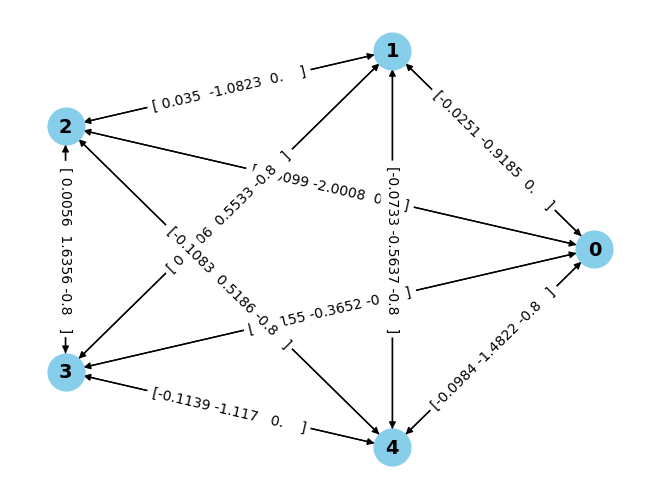

In [112]:
import networkx as nx
import matplotlib.pyplot as plt

a = 2
pos = nx.circular_layout(all_graphs5[a]) 

nx.draw(all_graphs5[a], pos, with_labels=True, font_weight='bold', node_color='skyblue', node_size=700, font_size=14)

edge_labels = {(u, v): str(data['weight']) for u, v, data in all_graphs5[a].edges(data=True)}
nx.draw_networkx_edge_labels(all_graphs5[a], pos, edge_labels=edge_labels)

plt.show()


In [11]:
def convert_to_pyg_data(graph):
    node_features = torch.ones((graph.number_of_nodes(), 1))


    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([graph[u][v]['weight'] for u, v in graph.edges()], dtype=torch.float)

    y = torch.tensor([data for _, data in graph.nodes(data='label')], dtype=torch.float)

    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=y)


In [12]:
def label_nodes1(G):
    labels = {}
    length = len(G.nodes())
    loss = 0
    reduce = 1
    if length == 3:
        loss = 1
    elif length == 6:
        loss = 0.5
    elif length == 10:
        loss = 0.33
    elif length == 15:
        loss = 0.25
    j = 1
    for i, node in enumerate(G.nodes()):
        labels[node] = 1 - reduce
        if (j * (j + 1)) // 2 == length:
            reduce = reduce - loss
            length = length - j 
            j = 0
        j = j + 1
    return labels

In [13]:
def label_nodes2(G):
    node_z_values = {}
    for node in G.nodes():
        for neighbor in G.neighbors(node):
            z_value = G[node][neighbor]['weight'][2]
            if node not in node_z_values or z_value > node_z_values[node]:
                node_z_values[node] = z_value

    groups = {}
    for node, z_value in node_z_values.items():
        groups.setdefault(z_value, []).append(node)

    sorted_groups = sorted(groups.items(), key=lambda item: item[0])

    labels = {}
    num_groups = len(sorted_groups)
    for i, (_, nodes) in enumerate(sorted_groups):
        label = i / (num_groups - 1) if num_groups > 1 else 1
        for node in nodes:
            labels[node] = round(label, 2)
    for node in G.nodes():
        if node not in labels:
            labels[node] = 0

    return labels


In [27]:
for graph in all_graphs1:
    labels = label_nodes(graph)
    nx.set_node_attributes(graph, labels, name='label')

In [28]:
for graph in all_graphs2:
    labels = label_nodes1(graph)
    nx.set_node_attributes(graph, labels, name='label')

In [143]:
for data in all_graphs3[0:1000]:    
    labels = {}
    labels_list = [0,0,0,0.5,0.5,1]
    for node in data.nodes():
        labels[node] = labels_list[node]    
    nx.set_node_attributes(data, labels, name='label')
for data in all_graphs3[1000:2000]:    
    labels = {}
    labels_list = [0,0,1,1]
    for node in data.nodes():
        labels[node] = labels_list[node] 
    nx.set_node_attributes(data, labels, name='label')
for data in all_graphs3[2000:3000]:    
    labels = {}
    labels_list = [0,0,0.5,0.5,1]
    for node in data.nodes():
        labels[node] = labels_list[node]    
    nx.set_node_attributes(data, labels, name='label')
for data in all_graphs3[3000:4000]:    
    labels = {}
    labels_list = [0,0,0.5,1]
    for node in data.nodes():
        labels[node] = labels_list[node]    
    nx.set_node_attributes(data, labels, name='label')

In [144]:
for data in all_graphs4[0:1000]:    
    labels = {}
    labels_list = [0,0,0,1,1]
    for node in data.nodes():
        labels[node] = labels_list[node]    
    nx.set_node_attributes(data, labels, name='label')
    
for data in all_graphs4[1000:2000]:    
    labels = {}
    labels_list = [0,0,1]
    for node in data.nodes():
        labels[node] = labels_list[node]    
    nx.set_node_attributes(data, labels, name='label')
    
for data in all_graphs4[2000:3000]:    
    labels = {}
    labels_list = [0,0,0,0.5,1]
    for node in data.nodes():
        labels[node] = labels_list[node]    
    nx.set_node_attributes(data, labels, name='label')
    
for data in all_graphs4[3000:4000]:    
    labels = {}
    labels_list = [0,0.5,0.5,1]
    for node in data.nodes():
        labels[node] = labels_list[node]    
    nx.set_node_attributes(data, labels, name='label')

In [149]:
for graph in all_graphs5:
    labels = label_nodes2(graph)
    nx.set_node_attributes(graph, labels, name='label')

In [29]:
pyg_graphs1 = [convert_to_pyg_data(graph) for graph in all_graphs1]


In [30]:
pyg_graphs2 = [convert_to_pyg_data(graph) for graph in all_graphs2]


In [152]:
pyg_graphs3 = [convert_to_pyg_data(graph) for graph in all_graphs3]

In [153]:
pyg_graphs4 = [convert_to_pyg_data(graph) for graph in all_graphs4]

In [154]:
pyg_graphs5 = [convert_to_pyg_data(graph) for graph in all_graphs5]

In [36]:
pyg_graphs = pyg_graphs1 + pyg_graphs2 

In [37]:
import random

def split_graphs(graphs, train_ratio=0.8):
    random.shuffle(graphs)
    num_train = int(len(graphs) * train_ratio)
    train_graphs = graphs[:num_train]
    test_graphs = graphs[num_train:]
    return train_graphs, test_graphs

train_dataset, test_dataset = split_graphs(pyg_graphs)

In [38]:
from sklearn.model_selection import KFold

def k_fold_split(graphs, num_folds=5, shuffle=True):
    if shuffle:
        random.shuffle(graphs)
    kf = KFold(n_splits=num_folds)
    fold_datasets = []
    for train_idx, test_idx in kf.split(graphs):
        train_graphs = [graphs[i] for i in train_idx]
        test_graphs = [graphs[i] for i in test_idx]
        fold_datasets.append((train_graphs, test_graphs))
    return fold_datasets

fold_datasets = k_fold_split(pyg_graphs, num_folds=5)

In [39]:
from torch_geometric.data import DataLoader
import torch
import csv
def calculate_accuracy(predictions, targets):
    # Convert predictions to binary values
    predictions = predictions > 0.9
    targets = targets > 0.9
    correct = (predictions == targets).sum()
    return correct / targets.numel()

num_epochs = 15
metrics = []
in_channels = 1  
hidden_channels = 32  
out_channels = 1

model = GNNModel(in_channels, hidden_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

for fold_idx, (train_dataset, test_dataset) in enumerate(fold_datasets):
    print(f'Fold {fold_idx}')
    train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for data in train_loader:
            out = model(data)
            loss = criterion(out , data.y.view(-1, 1))  # Ensure the target shape matches the output
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Calculate training accuracy
        train_acc = calculate_accuracy(out, data.y.view(-1, 1))

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_acc = 0
            for data in test_loader:
                out = model(data)
                test_acc += calculate_accuracy(out, data.y.view(-1, 1))
            test_acc /= len(test_loader)
        #metrics.append([total_loss / len(train_loader), train_acc, train_f1, test_acc, test_f1])
        print(f"Epoch {epoch}: Train Loss: {total_loss / len(train_loader):.3f}, Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}")

Fold 0


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16178x32 and 5x32)

In [161]:
import matplotlib.pyplot as plt

# Assuming 'metrics' is your list containing the training data

# Extracting each metric into its own list
train_losses = [epoch_metrics[0] for epoch_metrics in metrics]
train_accuracies = [epoch_metrics[1].item() for epoch_metrics in metrics]
train_f1s = [epoch_metrics[2].item() for epoch_metrics in metrics]
test_accuracies = [epoch_metrics[3].item() for epoch_metrics in metrics]
test_f1s = [epoch_metrics[4].item() for epoch_metrics in metrics]

# Number of epochs
epochs = range(1, len(metrics) + 1)

# Plot for Training and Testing Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, marker='o', color='blue', label='Train Accuracy')
plt.plot(epochs, test_accuracies, marker='o', color='red', label='Test Accuracy')
plt.title('Training and Testing Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('train_test_accuracy.png')
plt.close()

# Plot for Training Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', color='green', label='Train Loss')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('training_loss.png')
plt.close()

# Plot for F1 Scores
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_f1s, marker='o', color='orange', label='Train F1 Score')
plt.plot(epochs, test_f1s, marker='o', color='purple', label='Test F1 Score')
plt.title('F1 Scores Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('f1_scores.png')
plt.close()


In [34]:

model_path = "last_model1.pth"
torch.save(model.state_dict(), model_path)

In [29]:
in_channels = 1  
hidden_channels = 32  
out_channels = 1

#model = GNNModel(in_channels, hidden_channels, out_channels)

#model_path = 'sixth_model.pth'  # Update with your file path
#model.load_state_dict(torch.load(model_path))

random_index = random.randint(0, len(test_dataset) - 1)
test_data = test_dataset[random_index]

print(test_data)


print("Number of nodes:", test_data.num_nodes)
print("Number of edges:", test_data.num_edges)
if test_data.x is not None:
    print("Features shape:", test_data.x.shape)
else:
    print("No node features")

# Perform inference
model.eval()
with torch.no_grad():
    # Adding batch dimension if required by the model
    if test_data.num_nodes != 1:
        prediction = model(test_data)
        prediction = prediction.squeeze()
    
        #predicted_probs = torch.sigmoid(prediction)
        predicted_probs = prediction
        print(predicted_probs)
        predicted_classes = (predicted_probs > 0.5).int()

        print("Prediction shape:", prediction.shape)
        for i in range(test_data.num_nodes):
            print(f"Node {i}: Predicted class - {predicted_classes[i].item()}, Ground truth - {test_data.y[i].item()}")


Data(x=[7, 1], edge_index=[2, 42], edge_attr=[42, 3], y=[7])
Number of nodes: 7
Number of edges: 42
Features shape: torch.Size([7, 1])
tensor([0.9630, 0.8225, 0.8821, 0.4865, 0.5199, 0.1139, 0.1553])
Prediction shape: torch.Size([7])
Node 0: Predicted class - 1, Ground truth - 1.0
Node 1: Predicted class - 1, Ground truth - 1.0
Node 2: Predicted class - 1, Ground truth - 1.0
Node 3: Predicted class - 0, Ground truth - 0.5
Node 4: Predicted class - 1, Ground truth - 0.0
Node 5: Predicted class - 0, Ground truth - 0.5
Node 6: Predicted class - 0, Ground truth - 0.0
